### Context

The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications.

To stimulate the community to develop more drop-in replacements, **the Sign Language MNIST** presented here follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent **a multi-class problem with 24 classes of letters (excluding J and Z which require motion).**

### The dataset

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

> You can find more informations and download the train and test sets on [here on Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist)


### Project goal

The objective of this project is to train a classifier to recognize the hand sign on each image.

In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [ ]:
os.environ['USERNAME'] = "<your-kaggle-username>"
os.environ['KAGGLE_API_KEY'] = "<your-generated-Kaggle-API-Key>"

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

In [ ]:
!unzip sign-language-mnist.zip

In [ ]:
!rm sign-language-mnist.zip

In [2]:
# Load the CSV files into pandas DataFrames
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [3]:
# Ckeck lables
train_df['label'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

26 - 2 because no sign for 9 and 25 that are represented by motion.

In [4]:
# Preview the data
train_df.sample(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
21000,13,135,138,143,146,150,154,155,160,162,...,47,63,62,60,96,141,126,136,135,155
18068,22,124,128,133,137,141,144,145,146,149,...,140,114,82,103,187,185,186,187,187,187
16984,19,168,170,172,175,177,177,178,178,178,...,239,239,239,238,238,239,241,240,238,232
11169,4,172,174,176,177,180,180,180,182,182,...,75,159,228,226,227,227,227,226,227,227
4729,15,98,101,107,117,127,135,141,144,146,...,45,42,36,35,31,22,5,135,223,215
15929,8,161,164,166,170,171,175,178,179,181,...,175,207,208,208,207,205,204,205,195,156
11097,0,130,134,136,137,139,141,143,145,145,...,71,192,187,194,193,192,193,194,193,193
21640,1,93,99,107,110,113,117,121,122,124,...,162,158,161,161,162,163,162,162,162,163
8094,18,114,116,118,120,122,123,124,124,125,...,163,159,160,161,162,161,160,161,161,162
5441,5,139,142,146,149,151,153,155,156,159,...,54,44,38,49,55,53,38,34,40,43


In [5]:
train_df['label'] = train_df.label.astype(int)

### EDA (Quick)

Train set shape: (27455, 785)
Test set shape: (7172, 785)

Missing values in train set:
0
Missing values in test set:
0


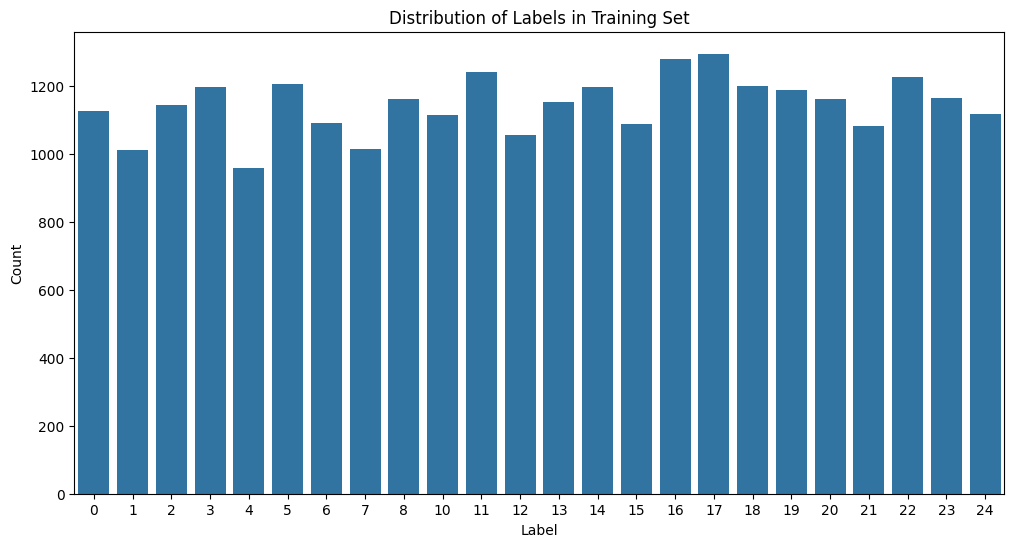

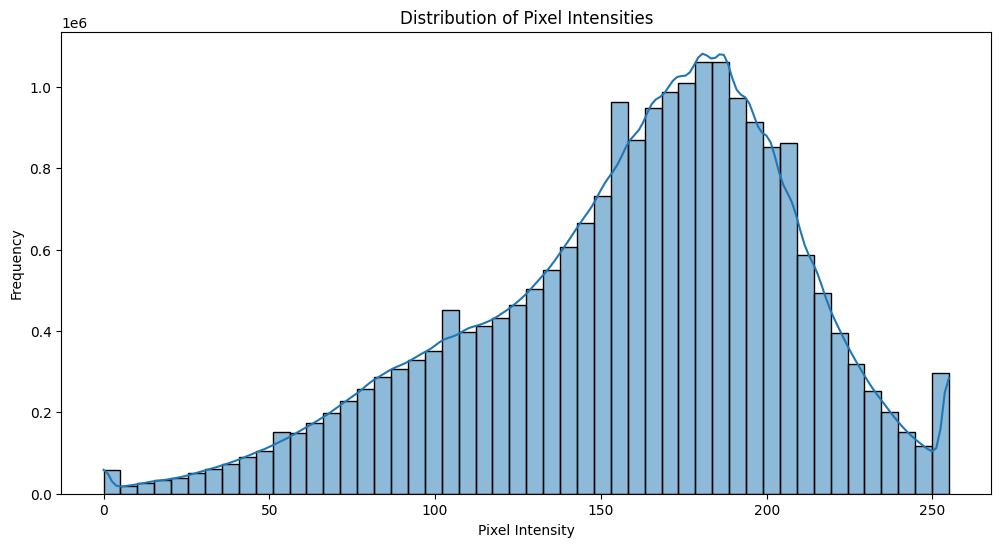

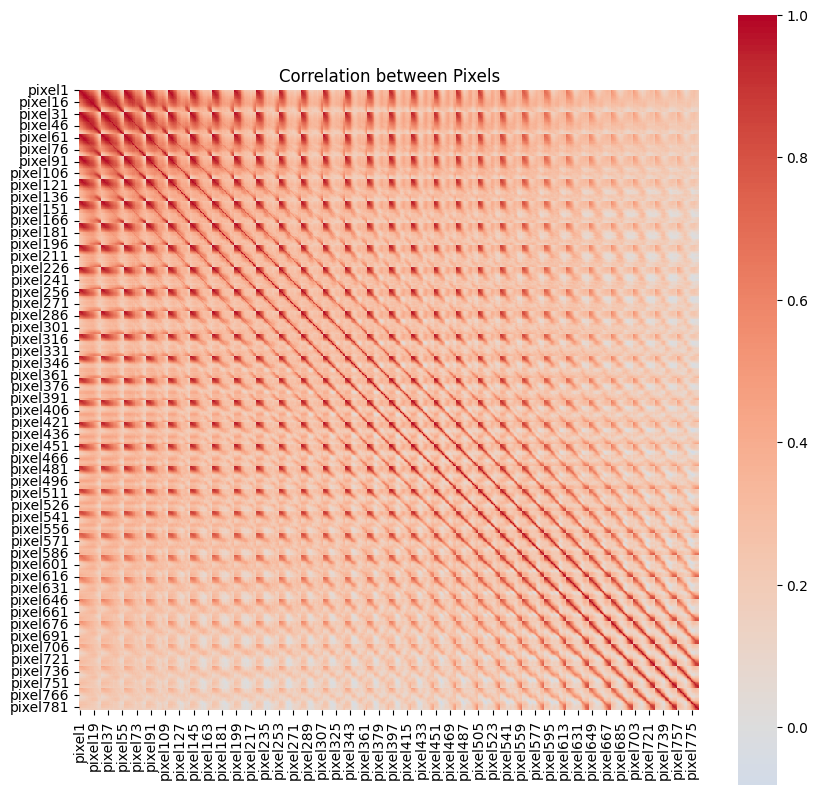

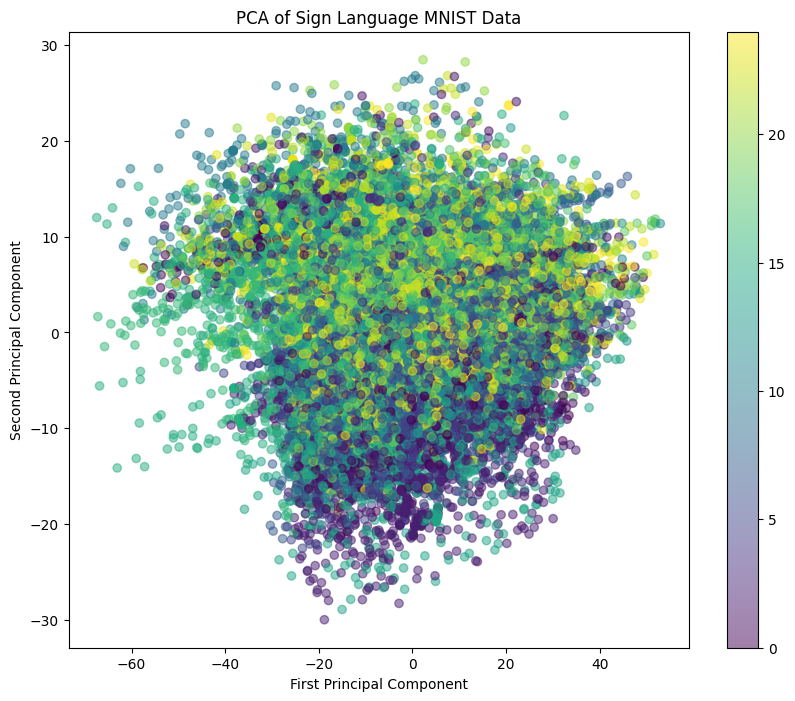

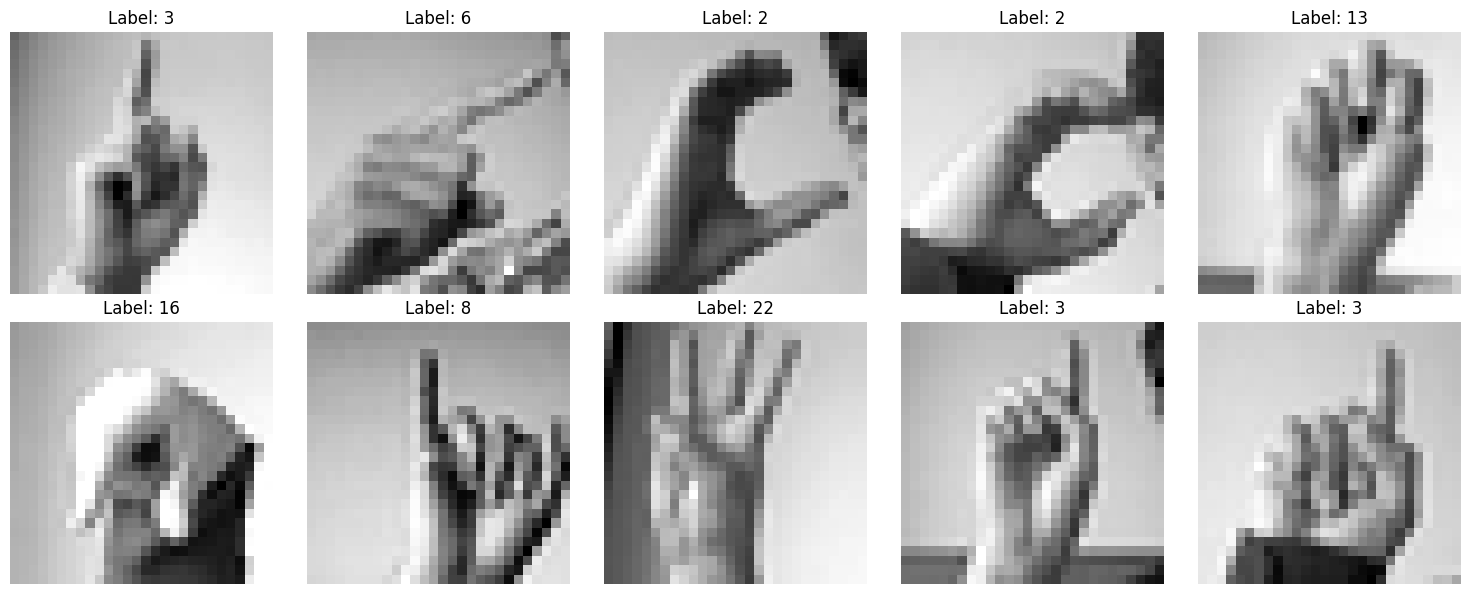


Statistics of pixel intensities:
             pixel1        pixel2        pixel3        pixel4        pixel5  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     145.419377    148.500273    151.247714    153.546531    156.210891   
std       41.358555     39.942152     39.056286     38.595247     37.111165   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      121.000000    126.000000    130.000000    133.000000    137.000000   
50%      150.000000    153.000000    156.000000    158.000000    160.000000   
75%      174.000000    176.000000    178.000000    179.000000    181.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

             pixel6        pixel7        pixel8        pixel9       pixel10  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     158.411255    160.472154    162.339683    163.954799    165.533673   
std       36.1255

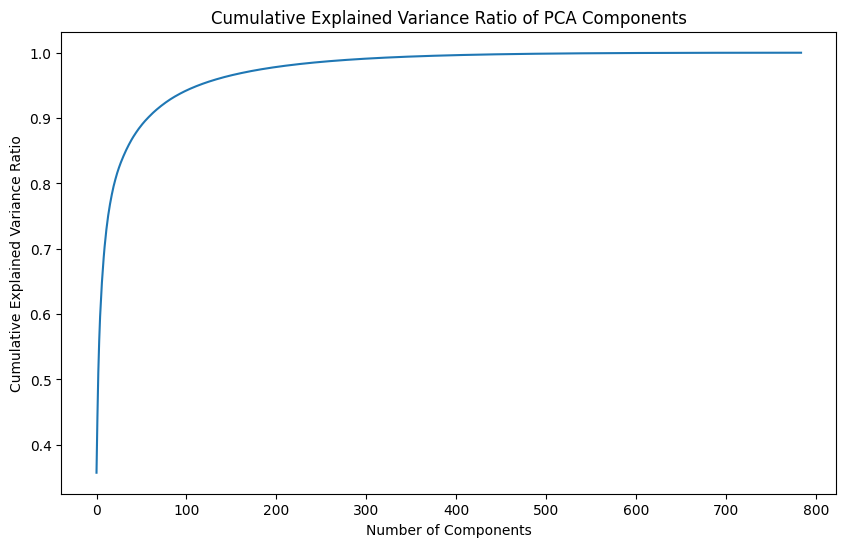

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the data
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# Basic information
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Check for missing values
print("\nMissing values in train set:")
print(train_df.isnull().sum().sum())
print("Missing values in test set:")
print(test_df.isnull().sum().sum())

# Distribution of labels
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Pixel intensity distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_df.iloc[:, 1:].values.ravel(), bins=50, kde=True)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Correlation between pixels
pixel_corr = train_df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(pixel_corr, cmap='coolwarm', center=0, square=True)
plt.title('Correlation between Pixels')
plt.show()

# PCA for dimensionality reduction and visualization
from sklearn.decomposition import PCA

X = train_df.drop('label', axis=1)
y = train_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('PCA of Sign Language MNIST Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = train_df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {train_df.iloc[i, 0]}")
plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics of pixel intensities:")
print(train_df.iloc[:, 1:].describe())

# Class balance
class_balance = train_df['label'].value_counts(normalize=True)
print("\nClass balance:")
print(class_balance)

# Explained variance ratio of PCA
pca_full = PCA()
pca_full.fit(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [8]:
y_train = train_df['label']
y_test = test_df['label']

In [ ]:
# del train_df['label']
# del test_df['label']

In [9]:
X_train = train_df.drop(columns='label')
X_test = test_df.drop(columns='label')

In [10]:
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27455, 784), (27455,), (7172, 784), (7172,))

In [12]:
X_train = X_train.values
X_test = X_test.values

In [13]:
# Normalization
X_train = X_train/255.
X_test = X_test/255.

In [14]:
# Maping categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
px = int(np.sqrt(X_train.shape[1]))

In [16]:
# Reshape features
X_train = X_train.reshape(-1, px, px, 1)
X_test = X_test.reshape(-1, px, px, 1)

# X_train = np.expand_dims(X_train, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

In [17]:
X_train.shape, X_test.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

Data is ready, let's build our model.

In [22]:
# CNN model, LeNet5 in 2D

def lenet5_2D(n_classes):
    model = Sequential(
        [
            Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),
            MaxPooling2D(),
            Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(84, activation='relu'),
            Dense(n_classes, 'softmax')
        ]
    )

    return model

In [23]:
n_classes = y_train.shape[1]
model_2D = lenet5_2D(n_classes)
model_2D.summary()

/Users/ismailsmac/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-01 19:26:53.220577: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-01 19:26:53.220733: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-01 19:26:53.220746: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-01 19:26:53.220919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-01 19:26:53.221094: I tensorflow/core/common_runtime/pluggable_devic

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,429 (189.18 KB)

 Trainable params: 48,429 (189.18 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_2D.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [25]:
model_2D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
os.makedirs('./Graph', exist_ok=True)

In [28]:
# Define callbacks before running the model
callbacks = [EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]

In [29]:
history = model_2D.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs=10, batch_size=64)

Epoch 1/10


2024-09-01 19:28:01.869532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


429/429 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.3031 - loss: 2.3082 - val_accuracy: 0.6953 - val_loss: 0.8796
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8563 - loss: 0.4610 - val_accuracy: 0.8681 - val_loss: 0.4574
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9804 - loss: 0.0944 - val_accuracy: 0.8657 - val_loss: 0.5635
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9945 - loss: 0.0323 - val_accuracy: 0.9060 - val_loss: 0.4158
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8975 - val_loss: 0.4608
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8981 - val_loss: 0.5102
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.9044 - val_loss: 0.5134
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9

In [30]:
print("Model accuracy on training set:", model_2D.evaluate(X_train, y_train, verbose=0)[1])
print("Model accuracy on test set:", model_2D.evaluate(X_test, y_test, verbose=0)[1])

Model accuracy on training set: 1.0
Model accuracy on test set: 0.9042108058929443


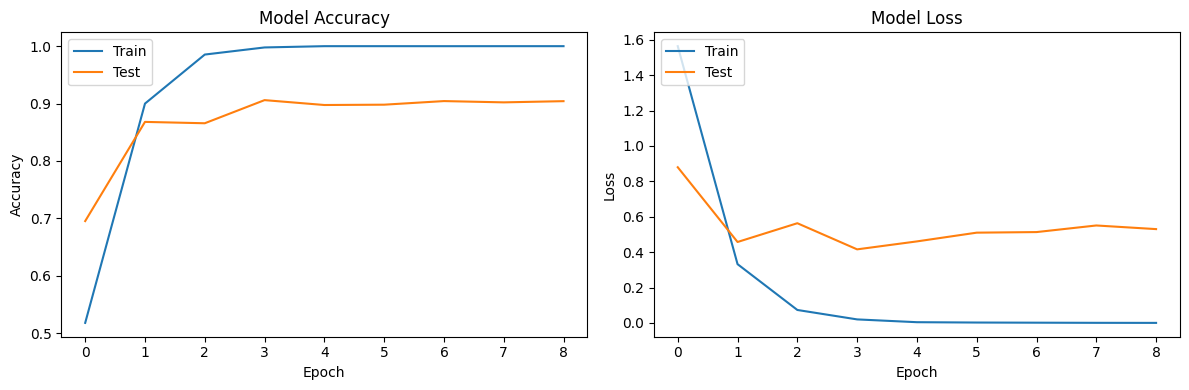

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

It seems like the model is overfitting, let's fix that.

### Data Augmentation

In [33]:
X_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


X_gen.fit(X_train)

In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

In [35]:
history = model_2D.fit(X_gen.flow(X_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (X_test, y_test) , callbacks = callbacks)

Epoch 1/20


/Users/ismailsmac/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5597 - loss: 1.7002 - val_accuracy: 0.8770 - val_loss: 0.3373 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8288 - loss: 0.5327 - val_accuracy: 0.9222 - val_loss: 0.2170 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8899 - loss: 0.3401 - val_accuracy: 0.9537 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9091 - loss: 0.2706 - val_accuracy: 0.9495 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9308 - loss: 0.2141 - val_accuracy: 0.9624 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9458 - loss: 0.1658 - val_accuracy: 0.9721 - val_loss: 0.0932 - learning_rate: 0.0010
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9528 - loss: 0.1497 - val_

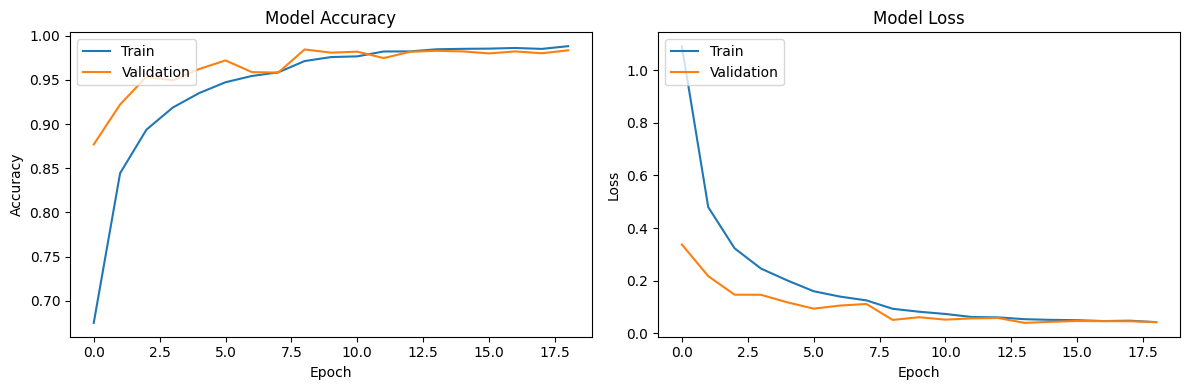

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Et voilà !